Corresponding video https://youtu.be/TH6vDphjZak

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('reg_house_data.csv')

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
num_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors']
cat_features = ['yr_built', 'condition']

In [5]:
X = data[[*num_features, *cat_features]]
y = data['price']

In [6]:
X.shape, y.shape

((20121, 6), (20121,))

In [7]:
X.yr_built.value_counts().sort_index()

1900     80
1901     28
1902     24
1903     45
1904     43
       ... 
2011    123
2012    161
2013    177
2014    492
2015     31
Name: yr_built, Length: 116, dtype: int64

In [8]:
X['decade_built'] = X.yr_built.apply(lambda x: (x-1900)//10)
X.drop('yr_built', axis=1, inplace=True)

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
X.condition.value_counts()

3    13072
4     5338
5     1512
2      170
1       29
Name: condition, dtype: int64

In [10]:
X.head()

,bedrooms,bathrooms,sqft_living,floors,condition,decade_built
0,3,1.00,1180,1.0,3,5
1,3,2.25,2570,2.0,3,5
2,2,1.00,770,1.0,3,3
3,4,3.00,1960,1.0,5,6
4,3,2.00,1680,1.0,3,8


# Linear model

1. Preprocess categorical features
2. Split data into train and test
3. Normalize the data
4. Built a baseline model
5. Optimize parameters of a linear model using grid search

### 1 Preprocess categorical features

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
ohe = OneHotEncoder(sparse=False)

In [13]:
encoded_features = pd.DataFrame(ohe.fit_transform(X[['condition', 'decade_built']]))

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [14]:
ohe.categories_

[array([1., 2., 3., 4., 5.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])]

In [15]:
condition_cols = [f'condition_{cat}' for cat in ohe.categories_[0]]
dec_built_cols = [f'dec_built_{cat}' for cat in ohe.categories_[1]]

In [16]:
dummy_cols_names = [*condition_cols, *dec_built_cols]
encoded_features.columns = dummy_cols_names

In [17]:
encoded_features

,condition_1.0,condition_2.0,condition_3.0,condition_4.0,condition_5.0,dec_built_0.0,dec_built_1.0,dec_built_2.0,dec_built_3.0,dec_built_4.0,dec_built_5.0,dec_built_6.0,dec_built_7.0,dec_built_8.0,dec_built_9.0,dec_built_10.0,dec_built_11.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20116,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20117,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20118,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20119,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
X.drop(['condition', 'decade_built'], axis=1, inplace=True)
# X = pd.concat([X, encoded_features], axis=1)

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
encoded_features

,condition_1.0,condition_2.0,condition_3.0,condition_4.0,condition_5.0,dec_built_0.0,dec_built_1.0,dec_built_2.0,dec_built_3.0,dec_built_4.0,dec_built_5.0,dec_built_6.0,dec_built_7.0,dec_built_8.0,dec_built_9.0,dec_built_10.0,dec_built_11.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20116,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20117,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20118,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20119,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
X = pd.concat([X, encoded_features], axis=1)

### 2 Split data into train and test

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

### 3 Normalize the data

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()
scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

### 4 Built a baseline model (Linear regression without regularization)

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [26]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [27]:
mse(y_test, y_pred)

20789964665.090965

In [28]:
test_error = mse(y_test, y_pred)

In [29]:
import numpy as np

In [30]:
# RMSE

np.sqrt(test_error)

144187.25555710867

In [31]:
y_test.mean()

467471.42078313255

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

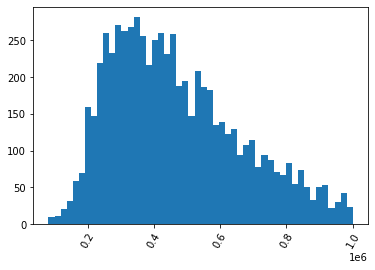

In [33]:
plt.hist(y_test, bins=50);
plt.xticks(rotation = 60);

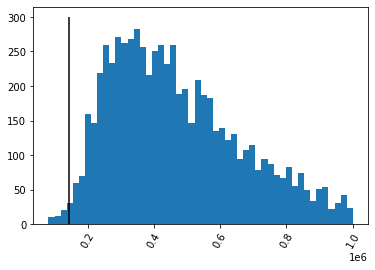

In [34]:
plt.hist(y_test, bins=50);
plt.xticks(rotation = 60);
plt.vlines(np.sqrt(test_error), 0, 300);

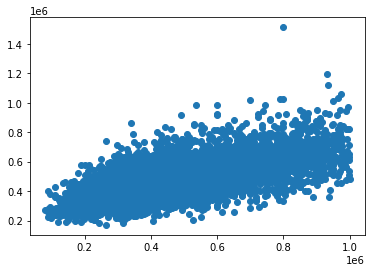

In [35]:
plt.scatter(y_test, y_pred);

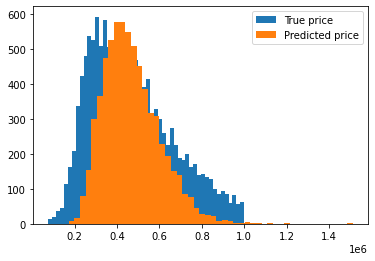

In [36]:
plt.hist(y_train, bins=50, label='True price');
plt.hist(y_pred, bins=50, label='Predicted price');
plt.legend();

### 5 Optimize parameters of a linear model

We will use Ridge regression.

In [37]:
from sklearn.linear_model import Ridge

# Train. Test. Validation.

Split data into 3 peices:

1. **Training part.** Used to fit a regression model. (model explicitly sees y_train)
2. **Validation part.** Used to optimize hyperparameters of the regression model. (model implicitly sees y_val)
3. **Test part.** Used to evaluate the perfomance of the model. (model does not see y_test at all)
---

1. Split data into Train, Validation and Test parts.
2. Train model on train part, optimize its hyperparameters using validation part.
3. After you choose best hyperparameters, train model on Train+Validation parts and predict on Test part to evaluate its perfomance.

In [38]:
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.33, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=1)

scaler = MinMaxScaler()
scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])

In [39]:
rmse_val = {}
for alpha in np.logspace(-6,1,20):
    reg = Ridge(alpha=alpha)
    reg.fit(X_train, y_train)
    y_val_pred = reg.predict(X_val)
    rmse_val[alpha] = np.sqrt(mse(y_val_pred, y_val))
    
print(min(rmse_val.items(), key=lambda x: x[1]))

(4.281332398719387, 147467.8913715514)


In [40]:
# Same train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# # Scale numeric features
scaler = MinMaxScaler()
scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# Train model with optimal hyperparameter
reg = Ridge(alpha=min(rmse_val.items(), key=lambda x: x[1])[0])
reg.fit(X_train, y_train)

# Predict on unseen data
y_pred = reg.predict(X_test)

# Compute model performance
np.sqrt(mse(y_test, y_pred))

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

144356.87691533894

In [1]:
plt.figure(figsize=(12,8))
plt.rc('font', **{'size':19})
plt.scatter(y_test, y_pred);
plt.plot([0,1_000_000], [0,1_000_000], c='r')
plt.xlabel('True price')
plt.ylabel('Predicted price');

NameError: name 'plt' is not defined

# What to do next?

1. Generate more features
2. Use another regression model